In [1]:
##new process 2024/7/04
import numpy as np
import pandas as pd
import itertools
import holoviews as hv
from holoviews import opts, dim
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import fisher_exact
sns.set()
import math
from scipy import integrate
from statsmodels.stats.multitest import multipletests
from mpl_chord_diagram import chord_diagram
from scipy.stats import chi2_contingency
import numpy as np
from scipy.stats import fisher_exact
from itertools import product
from matplotlib.colors import Normalize
# from bokeh.sampledata.airport_routes import routes, airports

In [2]:
##new process 2024/7/04
source=[]
target=[]
# df=[]
df_pair={}
source1=[]
target1=[]
value=[]
with open ("cluster_name.txt") as fname:
    for m in fname:
        genome_df={}
        m=m.strip()
        in_file=m
        with open (in_file+"_fre100_nine_one_contig_gene_81_contig_mobile_merge_fin_df_type_gene_sed.txt") as f,open("all_hotspot_df_type_gene_sort_chord1.txt","a") as fw:
            for i in f:
                i=i.strip().split("\t")
                genome_name="_".join(i[1].split("_")[:-1])
                if genome_name not in genome_df.keys():
                    genome_df[genome_name]=[[],[],[]]
                    genome_df[genome_name][0]=[i[0]]
                    genome_df[genome_name][1]=[i[1]]
                    genome_df[genome_name][2]=[i[2]]
                else:
                    genome_df[genome_name][0].append(i[0])
                    genome_df[genome_name][1].append(i[1])
                    genome_df[genome_name][2].append(i[2])
#             print(genome_df)
            for m,n in genome_df.items():
#                 print(n)
#                 df+=n[0]
                for nn in range(len(n[0])-1):
                    for mm in range(nn+1,len(n[0])):
                        print(n[0][nn],n[0][mm],file=fw)
                        if n[0][nn]+"+"+n[0][mm] not in df_pair.keys() and n[0][mm]+"+"+n[0][nn] not in df_pair.keys():
                            df_pair[n[0][nn]+"+"+n[0][mm]]=1
                        elif n[0][nn]+"+"+n[0][mm] in df_pair.keys():
                            df_pair[n[0][nn]+"+"+n[0][mm]]+=1
                        elif n[0][mm]+"+"+n[0][nn] in df_pair.keys():
                            df_pair[n[0][mm]+"+"+n[0][nn]]+=1
                        source.append(n[0][nn])
                        target.append(n[0][mm])
#             print(df_pair)
            
    for m1,n1 in df_pair.items():
        source1.append(m1.split("+")[0])
        target1.append(m1.split("+")[1])
        value.append(n1)
    data_df = pd.DataFrame({"source":source1,"target":target1,"frequency":value})
    data = pd.DataFrame({"source":source,"target":target})
        #     df1=list(set(df))
    with pd.option_context('display.max_rows', None,
                        'display.max_columns', None,
                        'display.precision', 3,
                        ):
        print(data_df)
#     print(len(list(set(df))))

                   source                 target  frequency
0          dCTP deaminase  Lamassu-Cap4_nuclease         37
1                    RM_I                   RloC         12
2                CBASS_II                CBASS_I          2
3                 Gao_Qat                  RM_II          5
4                    RM_I                 Gabija         18
5                   RM_II                   RM_I          2
6                   RM_II                 Gabija          2
7                  Gao_RL               RosmerTA          1
8              FS_GIY_YIG                  DRT_2          1
9              FS_GIY_YIG               RosmerTA          1
10                  DRT_2               RosmerTA          1
11                   RM_I                   AbiZ          2
12                  Septu                  DRT_2          5
13                  Septu         dCTP deaminase         27
14             pAgo_LongB              Retron_XI          1
15                   RM_I               

In [3]:
##new process 2024/7/04
# 将无向连接合并
merged_data = {}
for _, row in data_df.iterrows():
    source = row['source']
    target = row['target']
    frequency = row['frequency']
    
    if (source, target) in merged_data:
        merged_data[(source, target)] += frequency
    elif (target, source) in merged_data:
        merged_data[(target, source)] += frequency
    else:
        merged_data[(source, target)] = frequency

merged_df = pd.DataFrame([(k[0], k[1], v) for k, v in merged_data.items()], columns=['source', 'target', 'frequency'])
# print(merged_df)
# 获取所有的节点
nodes = sorted(list(set(merged_df['source']).union(set(merged_df['target']))))

# 创建一个空的连接频率矩阵
frequency_matrix = pd.DataFrame(0, index=nodes, columns=nodes, dtype=float)

# 填充矩阵
for _, row in merged_df.iterrows():
    source = row['source']
    target = row['target']
    frequency = row['frequency']
    frequency_matrix.loc[source, target] = frequency
    frequency_matrix.loc[target, source] = frequency  # 因为无向图，A到C和C到A频率相同

# print("Frequency Matrix:")
# print(frequency_matrix)

# 计算行和、列和及总和
row_sums = frequency_matrix.sum(axis=1)
col_sums = frequency_matrix.sum(axis=0)
total_sum = frequency_matrix.sum().sum()

# 计算期望频率矩阵
expected_matrix = pd.DataFrame(index=nodes, columns=nodes, dtype=float)
for node1 in nodes:
    for node2 in nodes:
        expected_matrix.loc[node1, node2] = (row_sums[node1] * col_sums[node2]) / total_sum

print("Expected Frequency Matrix:")
# print(expected_matrix)

# 创建一个空的p值矩阵
p_values_matrix = pd.DataFrame(np.nan, index=nodes, columns=nodes, dtype=float)

# 计算显著性
for node1 in nodes:
    for node2 in nodes:
        if node1 == node2:
            p_values_matrix.loc[node1, node2] = np.nan  # 自己与自己的显著性没有意义
        else:
            observed = np.array([[frequency_matrix.loc[node1, node2], row_sums[node1] - frequency_matrix.loc[node1, node2]],
                                 [col_sums[node2] - frequency_matrix.loc[node1, node2], total_sum - row_sums[node1] - col_sums[node2] + frequency_matrix.loc[node1, node2]]])

            # 确保列联表中的值都是非负数
            if np.any(observed < 0):
                p_values_matrix.loc[node1, node2] = np.nan
            else:
                # 进行卡方检验
                chi2, p_value, _, _ = chi2_contingency(observed, correction=False)
                p_values_matrix.loc[node1, node2] = p_value
#                 print(node1, node2 ,f"Chi2: {chi2}, p-value: {p_value}, degrees of freedom: 1")  # 自由度为1，因为每个独立单元格比较只有2行2列

print("P-values Matrix:")
# print(p_values_matrix)

# 提取所有非NaN的p值
p_values = p_values_matrix.values.flatten()
p_values = p_values[~np.isnan(p_values)]

# 进行BH校正
# _, p_values_corrected, _, _ = multipletests(p_values, method='fdr_bh')
_, p_values_corrected, _, _ = multipletests(p_values, method='fdr_bh')

# 将校正后的p值放回矩阵中
corrected_p_values_matrix = p_values_matrix.copy()
corrected_p_values_matrix.values[np.isnan(corrected_p_values_matrix.values) == False] = p_values_corrected
# print("corrected_p_values_matrix",corrected_p_values_matrix)
# output_file3 = "df_significance_matrix.csv"
# p_values_matrix.to_csv(output_file3, na_rep="NaN")
# print(f"Formatted Significance Matrix has been saved to {output_file3}")
# 将校正后的p值放回矩阵中
# corrected_p_values_matrix = p_values_matrix.copy()
# corrected_p_values_matrix.values[np.isnan(corrected_p_values_matrix.values) == False] = p_values_corrected
# output_file = "df_significance_matrix_ecpected.csv"
# expected_matrix.to_csv(output_file, na_rep="NaN")
# print(f"Formatted Significance Matrix has been saved to {output_file}")
# print("Corrected P-values Matrix:")
# print(corrected_p_values_matrix)
# output_file2 = "df_connection_frequency_matrix.csv"
# frequency_matrix.to_csv(output_file2, na_rep="NaN")
# print(f"Formatted Significance Matrix has been saved to {output_file2}")
# # display(pd.DataFrame(frequency_matrix))
# # output_file1 = "df_significance_matrix_bh.csv"
# corrected_p_values_matrix.to_csv(output_file1, na_rep="NaN")
# print(f"Formatted Significance Matrix has been saved to {output_file1}")
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(pd.DataFrame(corrected_p_values_matrix))

Expected Frequency Matrix:
P-values Matrix:
                            AbiD       AbiZ      BREX_I    CBASS_I   CBASS_II  \
AbiD                         NaN  9.832e-01   9.832e-01  9.832e-01  9.832e-01   
AbiZ                   9.832e-01        NaN   9.832e-01  9.832e-01  9.832e-01   
BREX_I                 9.832e-01  9.832e-01         NaN  9.832e-01  9.832e-01   
CBASS_I                9.832e-01  9.832e-01   9.832e-01        NaN  2.039e-04   
CBASS_II               9.832e-01  9.832e-01   9.832e-01  2.039e-04        NaN   
CRISPR-Cas IF          9.832e-01  9.832e-01   9.832e-01  9.832e-01  9.832e-01   
DRT_2                  9.832e-01  9.832e-01   9.832e-01  9.832e-01  9.832e-01   
DRT_3                  9.832e-01  9.832e-01   9.832e-01  9.832e-01  9.832e-01   
DarTG                  9.832e-01  9.832e-01  4.597e-199  9.832e-01  7.750e-01   
Druantia_III           9.832e-01  9.832e-01   9.832e-01  9.832e-01  9.832e-01   
Dsr_II                 9.832e-01  9.832e-01   9.832e-01  9.832e-0

In [4]:
##new process 2024/7/04
results = []
data=frequency_matrix.values
corr_matrix_fisher = np.zeros((data.shape[1], data.shape[1]))
p_matrix_fisher = np.zeros((data.shape[1], data.shape[1]))
p_matrix_fisher1 = np.zeros((data.shape[1], data.shape[1]))

# print(frequency_matrix.values)
# 遍历每个连接
zheng_p_value=[]
fu_p_value=[]
for i, j in product(range(frequency_matrix.values.shape[0]), range(frequency_matrix.values.shape[1])):
#     print(i,j)
    # 提取连接数
    connection = frequency_matrix.values[i, j]
    
    # 构造2x2子矩阵
    row_sum = np.sum(frequency_matrix.values[i, :]) - connection
    col_sum = np.sum(frequency_matrix.values[:, j]) - connection
    total_sum = np.sum(frequency_matrix.values) - row_sum - col_sum - connection
    
    sub_matrix = np.array([
        [connection, row_sum],
        [col_sum, total_sum]
    ])
    print(sub_matrix)
    print(sub_matrix+0.5)
    # Fisher精确检验
    oddsratio, p_value = fisher_exact(sub_matrix+0.5)
    print("oddratio:",oddsratio)
    if oddsratio<1:
        fu_p_value.append(-np.log10(p_value))
        if -np.log10(p_value)>3:
            p_matrix_fisher1[i, j] = -3
        else:
            p_matrix_fisher1[i, j] = np.log10(p_value)
#         fu_p_value.append(p_value)
    else:
#         print(oddsratio)
        zheng_p_value.append(-np.log10(p_value))
        if -np.log10(p_value)>3:
            p_matrix_fisher1[i, j] = 3
        else:
            p_matrix_fisher1[i, j] = -np.log10(p_value)
#         zheng_p_value.append(p_value)
    corr_matrix_fisher[i, j] = oddsratio
    p_matrix_fisher[i, j] = p_value
    # 保存结果
    results.append({
        'connection': (i, j),
        'oddsratio': oddsratio,
        'p_value': p_value
    })

# # 输出结果
# # print("oddsratio")
# # print("fu",fu_p_value)
# # print("zheng:",zheng_p_value)
# output_file = "df_fisher_corr_matrix_fin.csv"
# pd.DataFrame(corr_matrix_fisher).to_csv(output_file, na_rep="NaN")
# print(f"Formatted Significance Matrix has been saved to {output_file}")
# output_file1 = "df_fisher_pvalue_matrix_fin.csv"
# pd.DataFrame(p_matrix_fisher).to_csv(output_file1, na_rep="NaN")
# print(f"Formatted Significance Matrix has been saved to {output_file1}")

[[   0.   18.]
 [  18. 2224.]]
[[5.0000e-01 1.8500e+01]
 [1.8500e+01 2.2245e+03]]
oddratio: 0.0
[[0.00e+00 1.80e+01]
 [2.00e+00 2.24e+03]]
[[5.0000e-01 1.8500e+01]
 [2.5000e+00 2.2405e+03]]
oddratio: 0.0
[[   0.   18.]
 [  85. 2157.]]
[[5.0000e-01 1.8500e+01]
 [8.5500e+01 2.1575e+03]]
oddratio: 0.0
[[   0.   18.]
 [   7. 2235.]]
[[5.0000e-01 1.8500e+01]
 [7.5000e+00 2.2355e+03]]
oddratio: 0.0
[[   0.   18.]
 [  57. 2185.]]
[[5.0000e-01 1.8500e+01]
 [5.7500e+01 2.1855e+03]]
oddratio: 0.0
[[   0.   18.]
 [   9. 2233.]]
[[5.0000e-01 1.8500e+01]
 [9.5000e+00 2.2335e+03]]
oddratio: 0.0
[[   0.   18.]
 [   7. 2235.]]
[[5.0000e-01 1.8500e+01]
 [7.5000e+00 2.2355e+03]]
oddratio: 0.0
[[   0.   18.]
 [   7. 2235.]]
[[5.0000e-01 1.8500e+01]
 [7.5000e+00 2.2355e+03]]
oddratio: 0.0
[[   0.   18.]
 [ 103. 2139.]]
[[5.0000e-01 1.8500e+01]
 [1.0350e+02 2.1395e+03]]
oddratio: 0.0
[[   0.   18.]
 [  17. 2225.]]
[[5.0000e-01 1.8500e+01]
 [1.7500e+01 2.2255e+03]]
oddratio: 0.0
[[   0.   18.]
 [   9. 2233.

[[1.400e+01 2.000e+00]
 [2.900e+01 2.215e+03]]
[[  14.5    2.5]
 [  29.5 2215.5]]
oddratio: 534.6551724137931
[[0.000e+00 1.600e+01]
 [1.000e+00 2.243e+03]]
[[5.0000e-01 1.6500e+01]
 [1.5000e+00 2.2435e+03]]
oddratio: 0.0
[[   0.   16.]
 [ 239. 2005.]]
[[5.0000e-01 1.6500e+01]
 [2.3950e+02 2.0055e+03]]
oddratio: 0.0
[[0.000e+00 1.600e+01]
 [1.000e+00 2.243e+03]]
[[5.0000e-01 1.6500e+01]
 [1.5000e+00 2.2435e+03]]
oddratio: 0.0
[[   0.   16.]
 [   4. 2240.]]
[[5.0000e-01 1.6500e+01]
 [4.5000e+00 2.2405e+03]]
oddratio: 0.0
[[0.000e+00 1.600e+01]
 [2.000e+00 2.242e+03]]
[[5.0000e-01 1.6500e+01]
 [2.5000e+00 2.2425e+03]]
oddratio: 0.0
[[   0.   16.]
 [   8. 2236.]]
[[5.0000e-01 1.6500e+01]
 [8.5000e+00 2.2365e+03]]
oddratio: 0.0
[[   0.   16.]
 [  52. 2192.]]
[[5.0000e-01 1.6500e+01]
 [5.2500e+01 2.1925e+03]]
oddratio: 0.0
[[   0.   16.]
 [   5. 2239.]]
[[5.0000e-01 1.6500e+01]
 [5.5000e+00 2.2395e+03]]
oddratio: 0.0
[[   0.   16.]
 [  16. 2228.]]
[[5.0000e-01 1.6500e+01]
 [1.6500e+01 2.228

oddratio: 0.0
[[2.000e+00 3.400e+01]
 [2.000e+01 2.204e+03]]
[[   2.5   34.5]
 [  20.5 2204.5]]
oddratio: 6.482352941176471
[[0.000e+00 3.600e+01]
 [2.000e+00 2.222e+03]]
[[5.0000e-01 3.6500e+01]
 [2.5000e+00 2.2225e+03]]
oddratio: 0.0
[[   0.   36.]
 [   4. 2220.]]
[[5.0000e-01 3.6500e+01]
 [4.5000e+00 2.2205e+03]]
oddratio: 0.0
[[0.000e+00 3.600e+01]
 [1.000e+00 2.223e+03]]
[[5.0000e-01 3.6500e+01]
 [1.5000e+00 2.2235e+03]]
oddratio: 0.0
[[   0.   36.]
 [  15. 2209.]]
[[5.0000e-01 3.6500e+01]
 [1.5500e+01 2.2095e+03]]
oddratio: 0.0
[[   0.   36.]
 [   5. 2219.]]
[[5.0000e-01 3.6500e+01]
 [5.5000e+00 2.2195e+03]]
oddratio: 0.0
[[   0.   36.]
 [ 159. 2065.]]
[[5.0000e-01 3.6500e+01]
 [1.5950e+02 2.0655e+03]]
oddratio: 0.0
[[0.000e+00 3.600e+01]
 [1.000e+00 2.223e+03]]
[[5.0000e-01 3.6500e+01]
 [1.5000e+00 2.2235e+03]]
oddratio: 0.0
[[   0.   36.]
 [  31. 2193.]]
[[5.0000e-01 3.6500e+01]
 [3.1500e+01 2.1935e+03]]
oddratio: 0.0
[[   0.   36.]
 [  36. 2188.]]
[[5.0000e-01 3.6500e+01]
 [3.

In [5]:
with open("a1.txt") as f,open ("nine_one_df_name.txt_sed.txt") as f1:
    df=[]
    ht=[]
    for i in f:
        i=i.strip().split(",")
        ht=i
    for j in f1:
        j=j.strip()
        df.append(j)
color=[]
with open("color1") as f:
    for i in f:
        i=i.strip()
        color.append(i)
df_color={}
for ii in range(92):
    df_color[df[ii]]=color[ii]
for m,n in df_color.items():
    print(m,n)
print(df_color)
color2=[]
for iii in nodes:
    if iii in df_color.keys():
        color2.append(df_color[iii])
        print(iii,end=",")

AbiD #FFEBEE
AbiH #FFCDD2
AbiJ #EF9A9A
AbiL #E57373
AbiQ #EF5350
AbiU #F44336
AbiZ #E53935
Avs_II #FCE4EC
Avs_III #F8BBD0
Avs_IV #F48FB1
Avs_V #F06292
BREX_I #D32F2F
CapRel #C62828
CRISPR-Cas IF #EC407A
CBASS_I #E91E63
CBASS_II #B71C1C
DarTG #D81B60
Dazbog #C2185B
dCTP deaminase #AD1457
Detocs #880E4F
dGTPase #F3E5F5
Dnd_ABCDE #E1BEE7
Dnd_ABCDEFGH #CE93D8
DRT_2 #BA68C8
DRT_3 #AB47BC
DRT_8 #9C27B0
DRT_9 #8E24AA
Druantia_III #7B1FA2
Dsr_II #6A1B9A
Eleos #4A148C
FS_GIY_YIG #BBDEFB
Gabija #90CAF9
Gao_Her_DUF #64B5F6
Gao_Iet #42A5F5
Gao_Mza #2196F3
Gao_Ppl #1E88E5
Gao_Qat #1976D2
Gao_RL #1565C0
GAPS4 #0D47A1
Hachiman #FFCCBC
Hna #D1C4E9
Kiwa #B39DDB
Lamassu-Cap4_nuclease #9575CD
Lamassu-Fam #7E57C2
Lamassu-Hydrolase_Protease #673AB7
Lamassu-Mrr #5E35B1
Menshen #512DA8
Mokosh_Type_I_A #4527A0
Mokosh_Type_I_C #311B92
NLR_like_bNACHT01 #C5CAE9
Old_exonuclease #9FA8DA
Olokun #7986CB
pAgo_LongB #5C6BC0
PARIS_I #3F51B5
PARIS_II #3949AB
PARIS_II_merge #303F9F
PD-Lambda-1 #B3E5FC
PD-Lambda-2 #81D4F

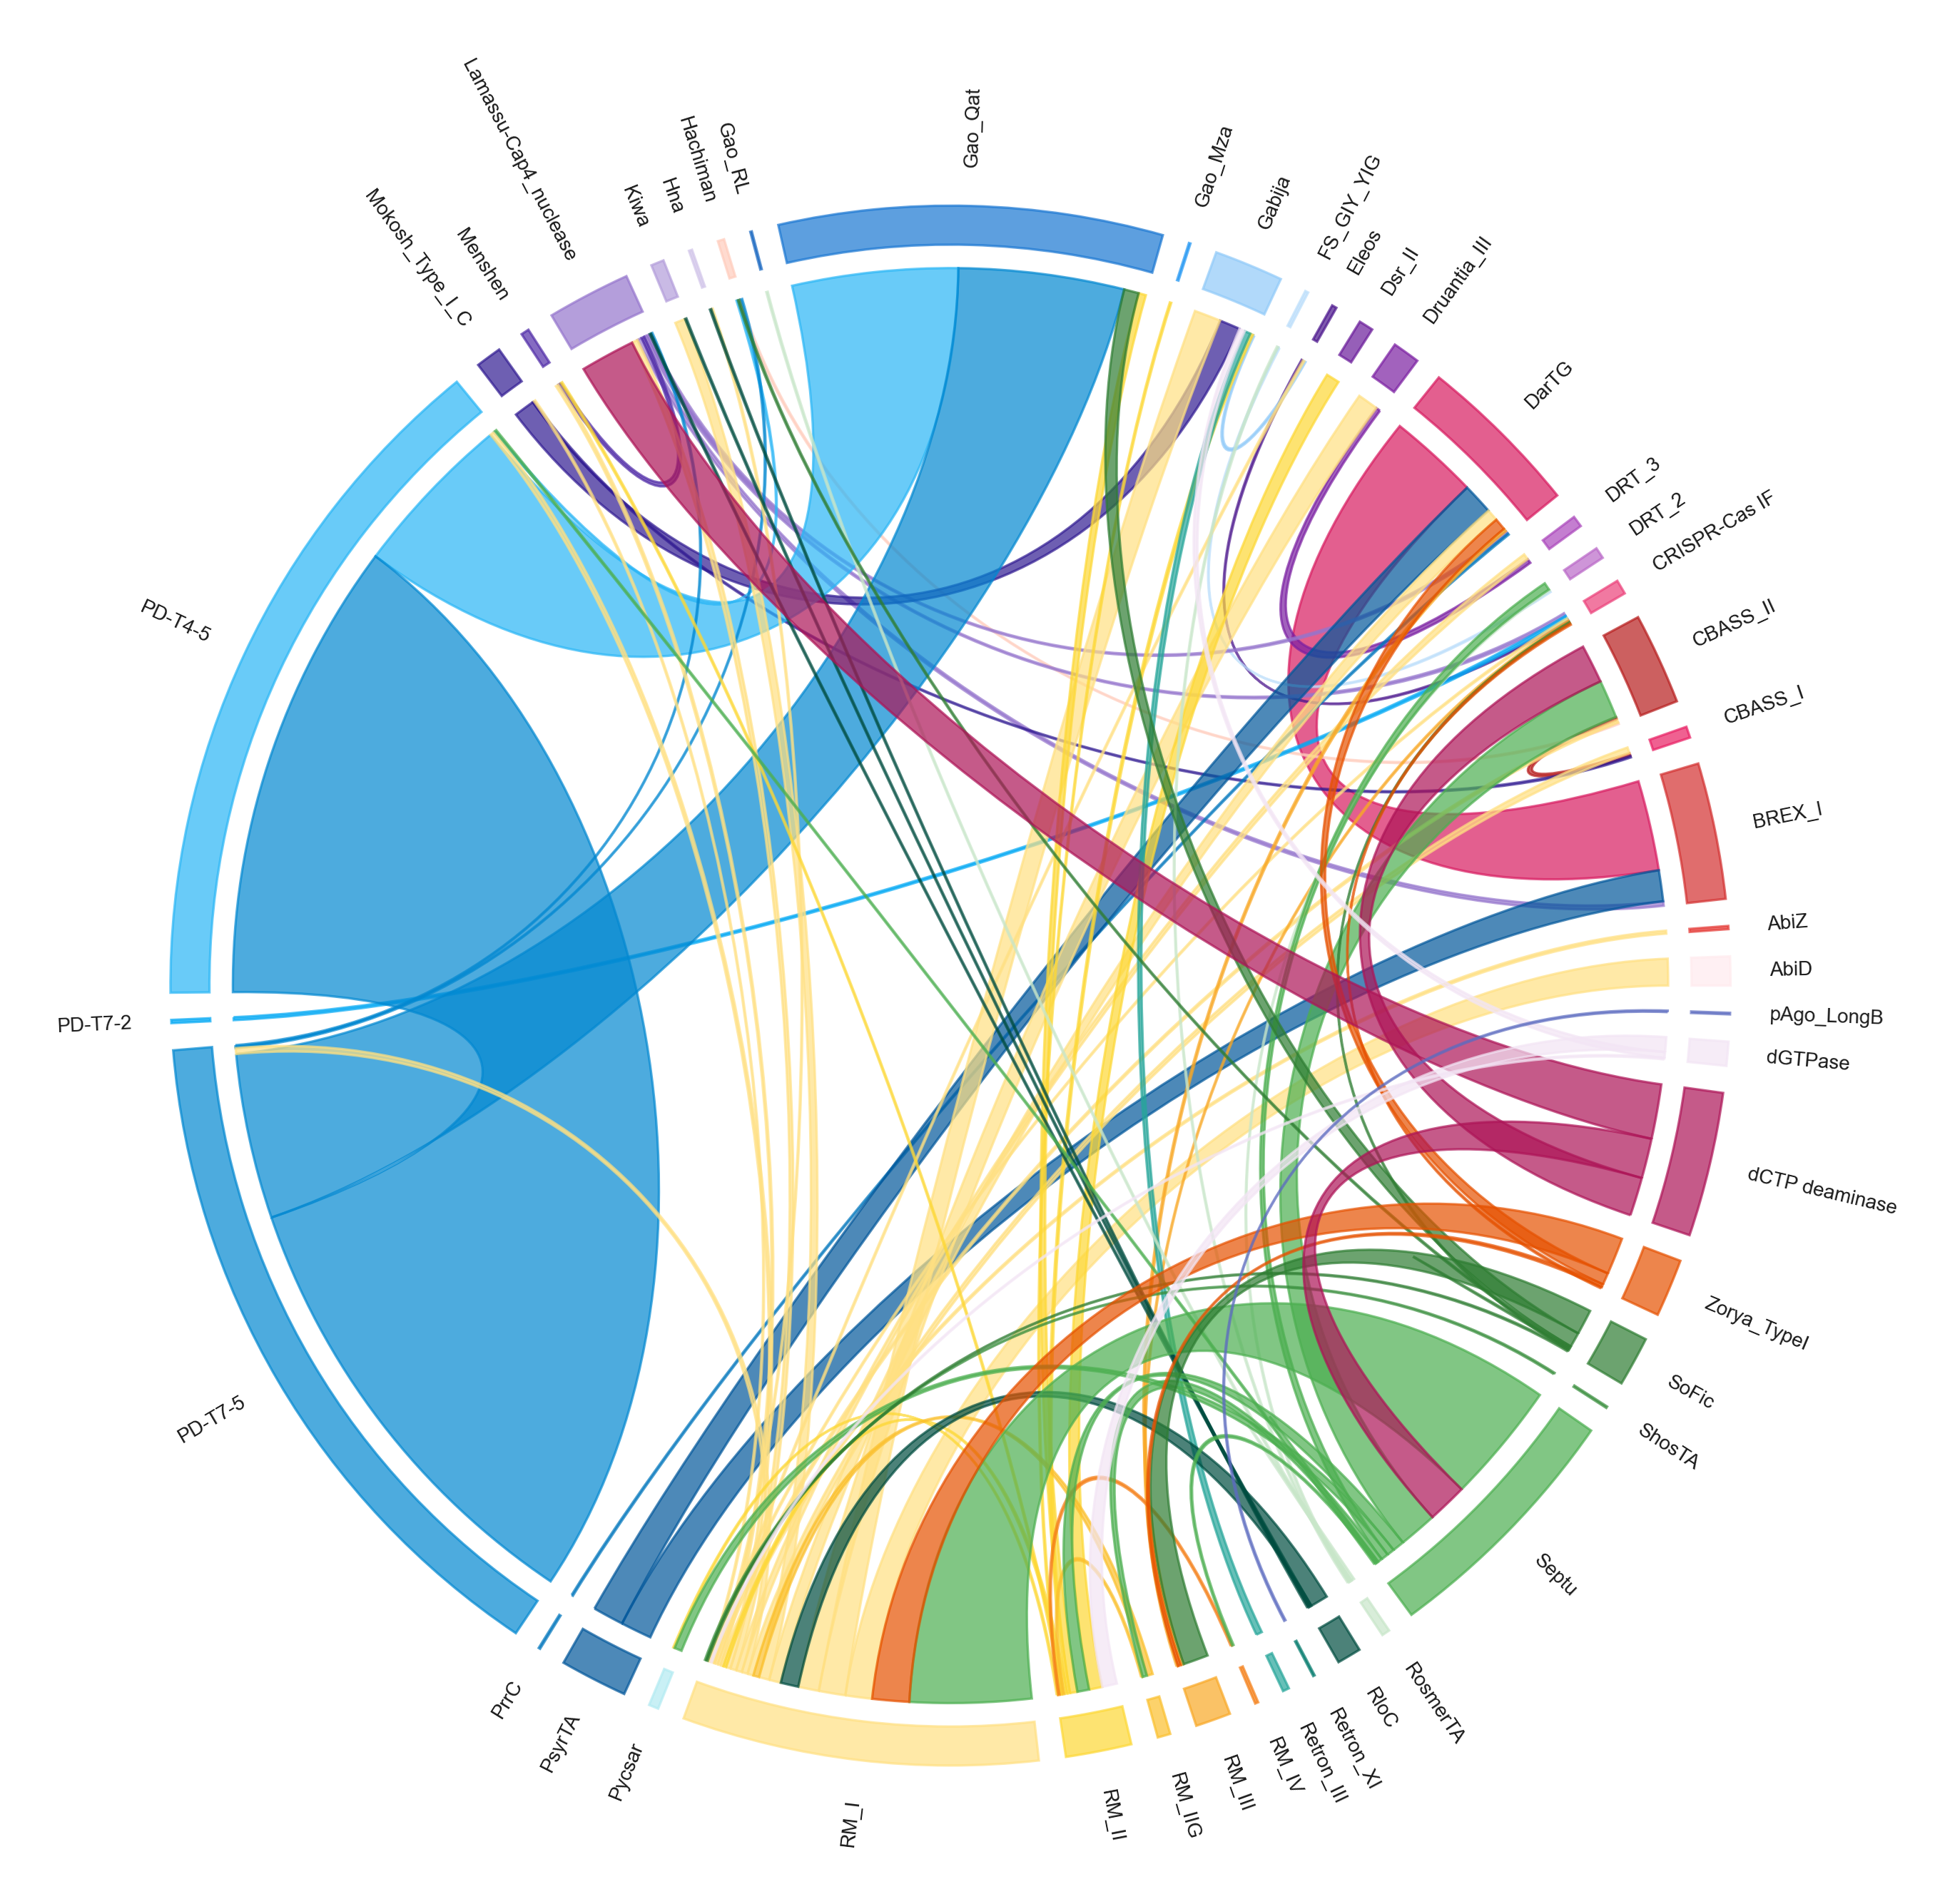

In [6]:
##new process 2024/7/04
fig,ax = plt.subplots(figsize=(4,3.5),dpi=800,facecolor="w")
color1=color[:-3]
# print(len(matrix[1]),len(list(set(names))))
chord_diagram(frequency_matrix,nodes,chordwidth=.5,width=.05,fontsize=2.5,ax=ax,colors=color2,rotate_names=90)
plt.tight_layout()
# fig.savefig("per_hotspot_df_connection_chord_fin_2024_7_04.png",dpi=1000)

In [8]:
with open("defense_mech1.txt",encoding="utf-8") as f:
    df_mech={}
    for i in f:
        i=i.strip().split("\t")
        df_mech[i[1]]=i[0]
    print(df_mech)

{'AbiD': 'Abi', 'AbiH': 'Abi', 'AbiJ': 'Abi', 'AbiL': 'Abi', 'AbiU': 'Abi', 'AbiZ': 'Abi', 'Avs_II': 'Abi', 'Avs_III': 'Abi', 'Avs_IV': 'Abi', 'BREX_I': 'RM and RM_like', 'CapRel': 'TA', 'CBASS_I': 'Abi', 'CBASS_II': 'Abi', 'CRISPR-Cas IF': 'Phage nucleic acid cleavage', 'DarTG': 'TA', 'Dazbog': 'Uknown', 'dCTP deaminase': 'TA', 'Detocs': 'Phage nucleic acid cleavage', 'dGTPase': 'Nucleotide Hydrolysis', 'Dnd_ABCDE': 'RM and RM_like', 'Dnd_ABCDEFGH': 'RM and RM_like', 'DRT_2': 'Abi', 'DRT_3': 'Abi', 'DRT_9': 'Abi', 'Druantia_III': 'Abi', 'Dsr_II': 'Abi', 'Eleos': 'Abi', 'FS_GIY_YIG': 'Phage nucleic acid cleavage', 'Gabija': 'Abi', 'Gao_Her_DUF': 'Uknown(与核酸代谢有关)', 'Gao_Iet': 'Uknown(与核酸代谢有关)', 'Gao_Mza': 'Uknown(与核酸代谢有关)', 'Gao_Ppl': 'Uknown(与核酸代谢有关)', 'Gao_Qat': 'Uknown(与核酸代谢有关)', 'Gao_RL': 'Uknown(与核酸代谢有关)', 'GAPS4': 'Protein-Protein Interaction', 'Hachiman': 'Abi', 'Hna': 'Phage nucleic acid cleavage', 'Kiwa': 'Calcium Regulation', 'Lamassu-Cap4_nuclease': 'Abi', 'Lamassu-Hydrolase_

C:\Users\41629\AppData\Local\Temp\ipykernel_35328\2904515340.py:35: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True,edgecolor='black', lw=1 ,color="white"))
C:\Users\41629\AppData\Local\Temp\ipykernel_35328\2904515340.py:29: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True,edgecolor='black', lw=1 ,color="#FEFFC0"))


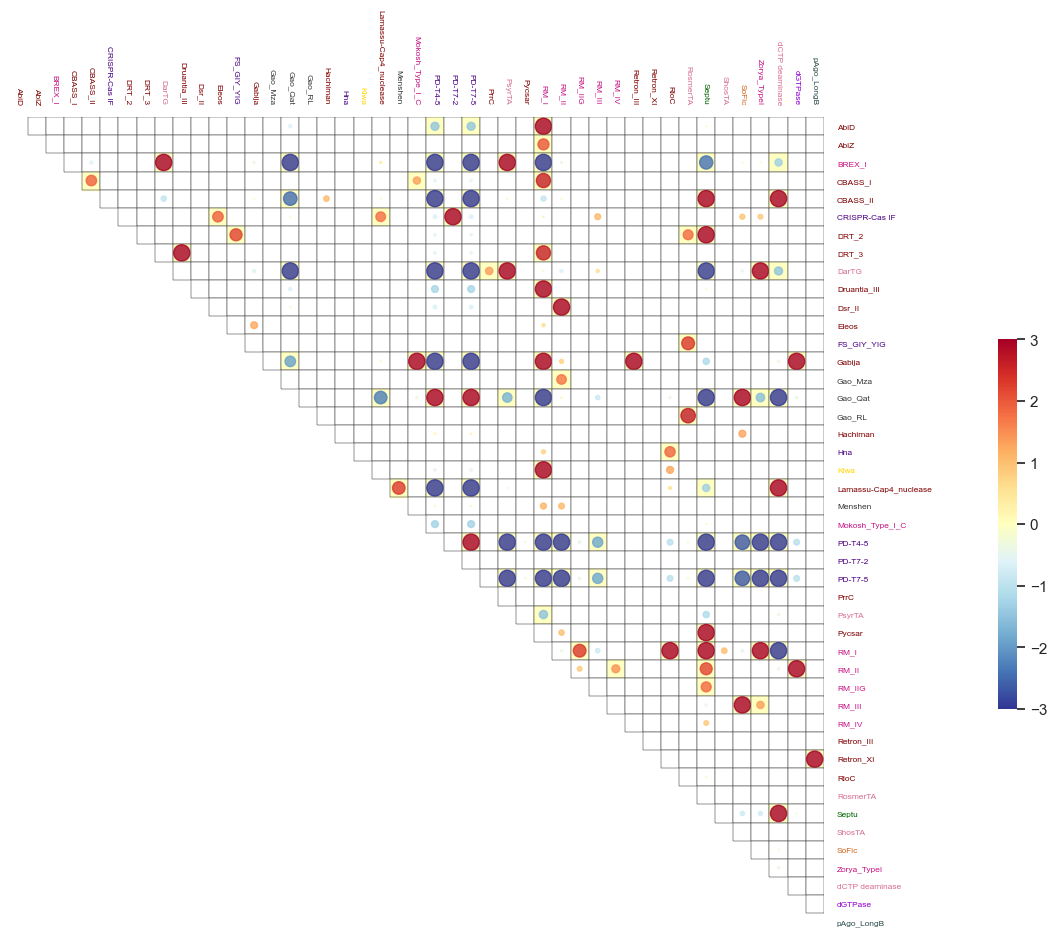

In [9]:
##new process 2024/7/04
sns.set_style("white")
config = {
    "font.family":'Times New Roman',  # 设置字体类型
#     "font.size": 80,
    "mathtext.fontset":'stix'
}
fig, ax = plt.subplots(figsize=(15, 12))

df=pd.DataFrame(p_matrix_fisher1)
# 创建一个热图但不显示颜色填充
mask=np.tri(45,45,0)
sns.heatmap(df, annot=False, cmap='RdYlBu_r', cbar=True, square=True, linewidths=0.5, linecolor='white',mask=mask, ax=ax,annot_kws={"fontsize":8},cbar_kws={"shrink": 0.4,"location": "right","pad": 0.15},)
norm = Normalize(vmin=df.values.min(), vmax=df.values.max())
cmap = plt.cm.RdYlBu_r

# 在热图的基础上添加白色背景并添加圆圈
for i in range(len(df)):
    for j in range(len(df.columns)):
        p_value = p_matrix_fisher[i, j]
        if j>i:
#             ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True,edgecolor='black', lw=1 ,color="white"))
#             ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False,edgecolor='black', lw=0.3))
#             size = df.iloc[i, j]*3  # 圆圈大小根据数据大小
#             color = cmap(norm(df.iloc[i, j]))  # 圆圈颜色根据数据大小
#             ax.add_patch(plt.Circle((j + 0.5, i + 0.5), size / 20, color=color, alpha=0.8))  # 调整除数以改变圆圈大小
            if p_value < 0.05:
                # 填充白色背景
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True,edgecolor='black', lw=1 ,color="#FEFFC0"))
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False,edgecolor='black', lw=0.3))
                size = df.iloc[i, j]*3  # 圆圈大小根据数据大小
                color = cmap(norm(df.iloc[i, j]))  # 圆圈颜色根据数据大小
                ax.add_patch(plt.Circle((j + 0.5, i + 0.5), size / 20, color=color, alpha=0.8))  # 调整除数以改变圆圈大小
            else:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True,edgecolor='black', lw=1 ,color="white"))
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False,edgecolor='black', lw=0.3))
                size = df.iloc[i, j]*3  # 圆圈大小根据数据大小
                color = cmap(norm(df.iloc[i, j]))  # 圆圈颜色根据数据大小
                ax.add_patch(plt.Circle((j + 0.5, i + 0.5), size / 20, color=color, alpha=0.8))  # 调整除数以改变圆圈大小
ax.set_xticks(np.arange(len(df.columns)) + 0.5)
ax.set_yticks(np.arange(len(df.index)) + 0.5)
ax.tick_params(axis='x', labeltop=True, labelbottom=False,rotation=270)
ax.tick_params(axis='y', labelright=True,labelleft=False,rotation=0)
x_labels=ax.set_xticklabels(nodes)
y_labels=ax.set_yticklabels(nodes)
for label in x_labels:
#     print("label",label.get_text())
    if df_mech[label.get_text()]=="Abi":
        label.set_color('#800000')
    elif df_mech[label.get_text()]=="RM and RM_like":
        label.set_color('#C71585')
    elif df_mech[label.get_text()]=='TA':
        label.set_color('#D87093')
    elif df_mech[label.get_text()]=="Phage nucleic acid cleavage":
        label.set_color('#4B0082')
    elif df_mech[label.get_text()]=="Nucleotide Hydrolysis":
        label.set_color('#9400D3')
    elif df_mech[label.get_text()]=="Protein-Protein Interaction" or df_mech[label.get_text()]=='protein-protein interactions':
        label.set_color('#D2691E')
    elif df_mech[label.get_text()]=="Calcium Regulation":
        label.set_color('#FFD700')
    elif df_mech[label.get_text()]=="Nucleic Acid Interference":
        label.set_color('#2F4F4F')
    elif df_mech[label.get_text()]=="Cytoskeleton Involvement":
        label.set_color('#006400')
    elif df_mech[label.get_text()]=="Cytokine Signaling":
        label.set_color('#1E90FF')
    elif df_mech[label.get_text()]=="ATPase Activity":
        label.set_color('#008080')
    else:
        label.set_color('#393b3c')
for label in y_labels:
#     print("label",label.get_text())
    if df_mech[label.get_text()]=="Abi":
        label.set_color('#800000')
    elif df_mech[label.get_text()]=="RM and RM_like":
        label.set_color('#C71585')
    elif df_mech[label.get_text()]=='TA':
        label.set_color('#D87093')
    elif df_mech[label.get_text()]=="Phage nucleic acid cleavage":
        label.set_color('#4B0082')
    elif df_mech[label.get_text()]=="Nucleotide Hydrolysis":
        label.set_color('#9400D3')
    elif df_mech[label.get_text()]=="Protein-Protein Interaction" or df_mech[label.get_text()]=='protein-protein interactions':
        label.set_color('#D2691E')
    elif df_mech[label.get_text()]=="Calcium Regulation":
        label.set_color('#FFD700')
    elif df_mech[label.get_text()]=="Nucleic Acid Interference":
        label.set_color('#2F4F4F')
    elif df_mech[label.get_text()]=="Cytoskeleton Involvement":
        label.set_color('#006400')
    elif df_mech[label.get_text()]=="Cytokine Signaling":
        label.set_color('#1E90FF')
    elif df_mech[label.get_text()]=="ATPase Activity":
        label.set_color('#008080')
    else:
        label.set_color('#393b3c')
    
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
# for i in range(data.shape[1]):
#     for j in range(data.shape[1]):
#         if j>i:
#             p_value = p_matrix_fisher[i, j]
#             if p_value < 0.01:
#                 plt.text(j + 0.5, i + 0.5, '***', ha='center', va='center', color='black', fontsize=8)
#             elif p_value < 0.05:
#                 plt.text(j + 0.5, i + 0.5, '**', ha='center', va='center', color='black', fontsize=8)
#             elif p_value < 0.1:
#                 plt.text(j + 0.5, i + 0.5, '*', ha='center', va='center', color='black', fontsize=8)

# plt.title('Per Hotspot Correlation Heatmap with $P-values$')
# fig.savefig("per_hotspot_Correlation_Heatmap_spearman.png", bbox_inches='tight',dpi=800) # 减少边缘空白
# plt.xlabel('Features')
# plt.ylabel('Features')
plt.show()
# fig.savefig("per_hotspot_df_connection_fisher_fin_2024_7_10.png",dpi=800)